In [42]:
import pandas as pd
import numpy as np
from tqdm import tqdm

In [47]:
def create_mask_HaTinh(list_path,selected_features=None):
    # 1) Đọc CSV và gộp

    if selected_features is None:
        selected_features = ['B04B', 'B10B', 'B11B', 'B16B', 'IRB',
                             'CAPE', 'R850', 'TCWV', 'U850', 'I2B', 'TCLW', 'TCW']
    dfs = []
    print("[B1] Đọc CSV...")
    for p in tqdm(list_path, desc="Đọc file CSV"):
        df = pd.read_csv(p)   # Mẹo: Xác định dtype ngay lúc đọc để tiết kiệm bộ nhớ nếu file lớn
        df["variable"] = df["variable"].astype(str)
        df.loc[df["variable"].isin(['2019', '2020']), "variable"] = 'y'   # Gán nhãn y
        dfs.append(df)
    df_all = pd.concat(dfs, ignore_index=True)

    # 2) Min/Max row/col → tạo hình chữ nhật
    min_row, max_row = df_all["row"].min(), df_all["row"].max()
    min_col, max_col = df_all["col"].min(), df_all["col"].max()
    n_row = int(max_row - min_row + 1)
    n_col = int(max_col - min_col + 1)

    # 3) Xác định danh sách band cần thiết (QUAN TRỌNG: Phải Sort để cố định thứ tự)
    required_bands_list = sorted(list(set(selected_features + ['y'])))
    required_bands_set = set(required_bands_list)
    print(f"-> Số lượng band bắt buộc: {len(required_bands_list)}")

    # 4) Lọc Timestamp hợp lệ (TỐI ƯU HÓA TỐC ĐỘ)
    print("[B2] Lọc timestamp đầy đủ (Vectorized Check)...")

    # Chỉ giữ lại các dòng thuộc các variable quan tâm để đếm cho nhanh
    df_check = df_all[df_all["variable"].isin(required_bands_set)]

    # Đếm số lượng variable unique trong mỗi timestamp
    # Nếu timestamp T1 có đủ 13 variable -> count sẽ là 13
    ts_counts = df_check.groupby("timestamp")["variable"].nunique()

    # Lấy ra các timestamp có số lượng variable bằng đúng số lượng yêu cầu
    valid_ts_index = ts_counts[ts_counts == len(required_bands_set)].index
    ts_valid = sorted(list(valid_ts_index))

    print(f"-> Tìm thấy {len(ts_valid)} timestamp hợp lệ.")

    # 5) Chuẩn bị dữ liệu để đổ vào Tensor
    print("[B3] Chuẩn bị index và Tensor...")

    # Tạo mapping index (Dictionary comprehension)
    t_to_idx = {t: i for i, t in enumerate(ts_valid)}
    b_to_idx = {b: i for i, b in enumerate(required_bands_list)} # Dùng list đã sort

    # Lọc dữ liệu chính thức:
    # - Chỉ lấy timestamp hợp lệ
    # - Chỉ lấy variable nằm trong required_bands (Bước này sửa lỗi Index Float)
    df_valid = df_all[
        (df_all["timestamp"].isin(ts_valid)) &
        (df_all["variable"].isin(required_bands_set))
    ].copy()

    # Map sang index (Ép kiểu int rõ ràng để tránh lỗi)
    df_valid["t_idx"] = df_valid["timestamp"].map(t_to_idx).astype(int)
    df_valid["b_idx"] = df_valid["variable"].map(b_to_idx).astype(int)
    df_valid["r_idx"] = (df_valid["row"] - min_row).astype(int)
    df_valid["c_idx"] = (df_valid["col"] - min_col).astype(int)

    # 6) Đổ dữ liệu vào Tensor (Vectorized - Không cần vòng lặp)
    print("[B4] Đổ dữ liệu vào Tensor...")
    # tensor = np.zeros((len(ts_valid), len(required_bands_list), n_row, n_col), dtype=float)

    tensor = np.full(
        (len(ts_valid), len(required_bands_list), n_row, n_col),
        -1,
        dtype=float
    )

    # Numpy Advanced Indexing: Nhanh hơn loop rất nhiều
    tensor[df_valid["t_idx"].values,
           df_valid["b_idx"].values,
           df_valid["r_idx"].values,
           df_valid["c_idx"].values] = df_valid["value"].values


    mask = (tensor >= 0).any(axis=(0, 1)).astype(np.uint8)
    np.save('../csv_data/old/mask_hatinh.npy', mask)


In [48]:
list_file = [
        '../csv_data/HIMA_hatinh.csv',
        '../csv_data/ERA5_hatinh.csv',
        '../csv_data/RADAR_hatinh.csv'
    ]
create_mask_HaTinh(list_file)



[B1] Đọc CSV...


Đọc file CSV: 100%|██████████| 3/3 [00:15<00:00,  5.17s/it]


-> Số lượng band bắt buộc: 13
[B2] Lọc timestamp đầy đủ (Vectorized Check)...
-> Tìm thấy 1223 timestamp hợp lệ.
[B3] Chuẩn bị index và Tensor...
[B4] Đổ dữ liệu vào Tensor...


In [50]:
mask_ht = np.load('../csv_data/old/mask_hatinh.npy')
print(mask_ht.shape)


(21, 34)


In [51]:
print(mask_ht)

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 1 1 0 0 0 1 1 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0]
 [0 0 

In [28]:
import geopandas as gpd
from rasterio import features
from rasterio.transform import from_origin
import numpy as np
import matplotlib.pyplot as plt

# === 1. ĐỌC SHAPEFILE VÀ LỌC HÀ TĨNH ===
shp_path = "../gadm41_VNM_shp"
vnm_gdf = gpd.read_file(shp_path)                 # Đọc toàn bộ shapefile Việt Nam
ht_gdf = vnm_gdf[vnm_gdf['VARNAME_1'] == 'Ha Tinh']  # Lọc riêng tỉnh Hà Tĩnh
ht_union = ht_gdf.union_all()                    # Gộp tất cả các polygon của Hà Tĩnh thành 1 polygon

# === 2. TÍNH BOUNDING BOX CỦA HÀ TĨNH ===
minx, miny, maxx, maxy = ht_union.bounds

# origin_x, origin_y là góc trên bên trái của raster
origin_x = minx
origin_y = maxy

# === 3. THÔNG SỐ RASTER MUỐN TẠO ===
res = 0.04                  # Độ phân giải (1 pixel = 0.04 độ)
req_height = 21             # Số dòng của raster (trùng với dữ liệu y_hatinh)
req_width = 34              # Số cột của raster

# Tạo affine transform để ánh xạ pixel (row, col) → tọa độ (lon, lat)
transform = from_origin(origin_x, origin_y, res, res)

# === 4. TẠO MASK VỚI KÍCH THƯỚC FIXED (21×34) ===
mask = ~features.geometry_mask(
    geometries=[ht_union],         # Hình đa giác của Hà Tĩnh
    out_shape=(req_height, req_width),  # Bắt buộc raster phải có kích thước 21×34
    transform=transform,
    invert=False,                   # False → bên trong polygon = False → sau đó mình đảo lại (~) thành 1
    all_touched=True                # Lấy tất cả pixel chạm biên (làm cho ranh giới đầy đủ hơn)
).astype("uint8")                   # Đưa về kiểu 0–1

# === 5. IN THÔNG TIN KIỂM TRA ===
print(f"Kích thước Mask: {mask.shape}")         # Dự kiến (21, 34)
print(f"Số điểm mưa trong Hà Tĩnh: {np.sum(mask)}")   # Số pixel = 1 (nằm trong tỉnh)


Kích thước Mask: (21, 34)
Số điểm mưa trong Hà Tĩnh: 181732


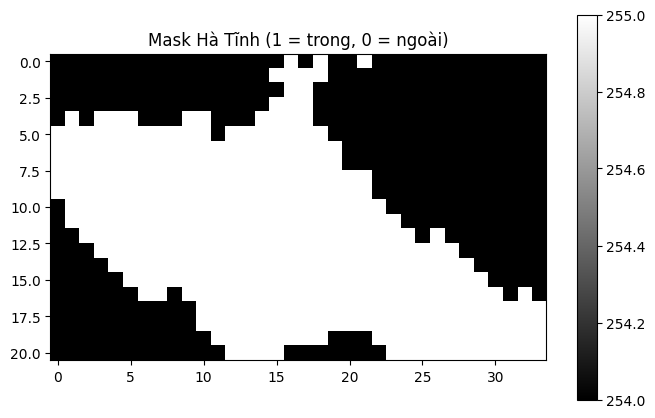

In [29]:
# --- Plot để kiểm tra ---
plt.figure(figsize=(8, 5))
plt.imshow(mask, cmap="gray")   # trắng = trong HT, đen = ngoài
plt.title("Mask Hà Tĩnh (1 = trong, 0 = ngoài)")
plt.colorbar()
plt.show()

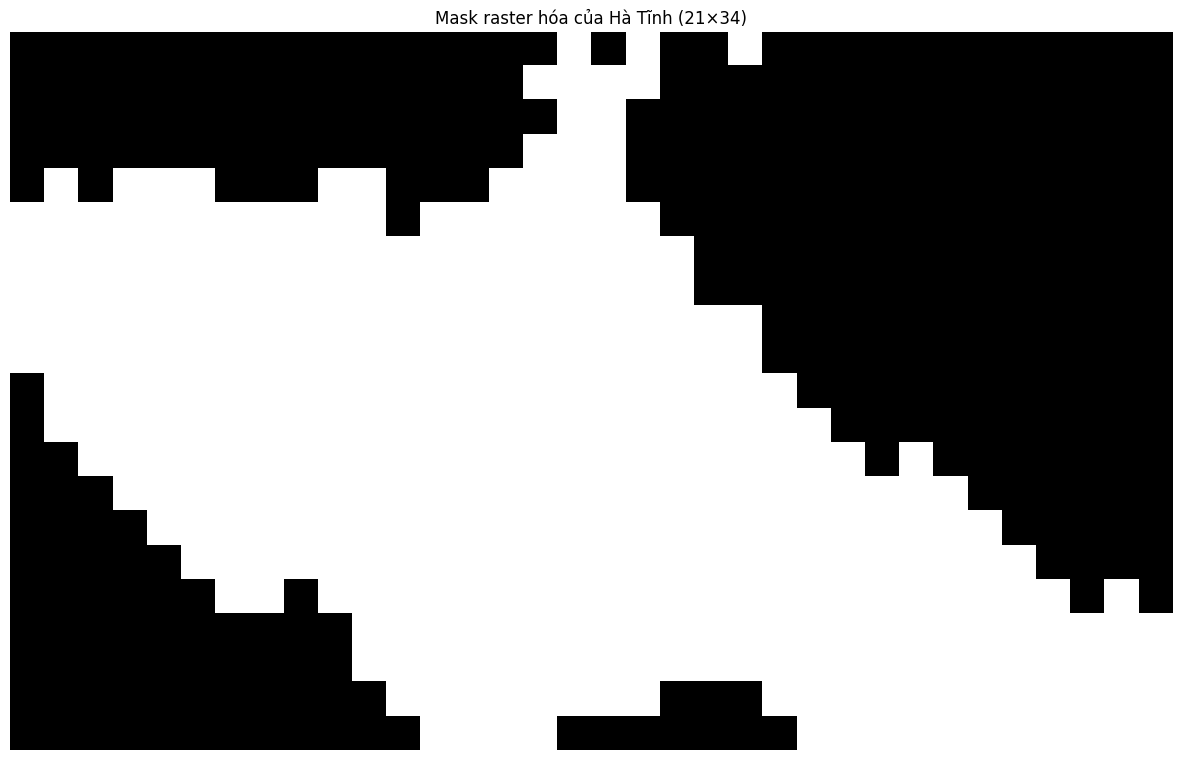

In [37]:
plt.figure(figsize=(15,10))
plt.imshow(mask, cmap="gray")
plt.title("Mask raster hóa của Hà Tĩnh (21×34)")
plt.axis("off")
plt.show()


In [30]:
yht = np.load('../csv_data/y_hatinh.npy')

In [31]:
total_pixels = yht.size                  # Tổng số điểm dữ liệu (Time x Row x Col)
zero_pixels = np.sum(yht == 0)           # Số lượng điểm bằng 0 tuyệt đối
near_zero_pixels = np.sum(yht < 0.1)     # Số lượng điểm rất nhỏ (gần như 0)
percent_zeros = (zero_pixels / total_pixels) * 100

print(f"1. Kích thước (Shape): {yht.shape}")
print(f"2. Tổng số pixel:      {yht.size:,}")
print(f"3. Số lượng giá trị 0: {zero_pixels:,}")
print(f"4. Tỷ lệ số 0:         {percent_zeros:.2f}%")
print(f"5. Giá trị lớn nhất Y:   {yht.max()}")
print(f"6. Giá trị nhỏ nhất Y:   {yht.min()}")

1. Kích thước (Shape): (1223, 21, 34)
2. Tổng số pixel:      873,222
3. Số lượng giá trị 0: 803,761
4. Tỷ lệ số 0:         92.05%
5. Giá trị lớn nhất Y:   260.0
6. Giá trị nhỏ nhất Y:   0.0


In [33]:
# --- BƯỚC 1: CHUẨN BỊ MASK ---
# Chuyển mask (0/1) sang dạng Boolean (True/False) để dùng làm bộ lọc
mask_bool = mask.astype(bool)

print(f"Số điểm không gian trong mask: {np.sum(mask_bool)}")
print(mask_bool.shape)
print(mask_bool)

Số điểm không gian trong mask: 714
(21, 34)
[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True 

In [ ]:
# --- BƯỚC 2: LỌC DỮ LIỆU (QUAN TRỌNG) ---
# Chúng ta chỉ lấy giá trị tại những nơi mask == True
# Kiểm tra số chiều của yht để lọc cho đúng
if yht.ndim == 3:
    # Trường hợp phổ biến: (Time, Height, Width) -> Kết quả sẽ là (Time, Số_điểm_mask)
    # Dấu ":" đầu tiên nghĩa là lấy tất cả các bước thời gian
    yht_filtered = yht[:, mask_bool]
elif yht.ndim == 2:
    # Trường hợp chỉ có 1 ảnh: (Height, Width) -> Kết quả là (Số_điểm_mask,)
    yht_filtered = yht[mask_bool]
else:
    raise ValueError(f"Dữ liệu yht có số chiều không mong muốn: {yht.ndim}")

# --- BƯỚC 3: TÍNH TOÁN THỐNG KÊ TRÊN DỮ LIỆU ĐÃ LỌC ---
# Làm phẳng mảng đã lọc ra chuỗi 1 chiều để tính toán tổng thể dễ dàng
data_stats = yht_filtered.flatten()

total_pixels_in_mask = data_stats.size
zero_pixels_in_mask = np.sum(data_stats == 0)
near_zero_pixels_in_mask = np.sum(data_stats < 0.1)
percent_zeros_mask = (zero_pixels_in_mask / total_pixels_in_mask) * 100 if total_pixels_in_mask > 0 else 0

In [ ]:
# --- BƯỚC 4: IN KẾT QUẢ ---
print("-" * 30)
print("THỐNG KÊ DỮ LIỆU CHỈ TRONG VÙNG MASK (HÀ TĨNH)")
print("-" * 30)
print(f"1. Kích thước mảng sau lọc:    {yht_filtered.shape}")
print(f"   (Lưu ý: Chiều thứ 2 chính là số điểm không gian nằm trong tỉnh)")
print(f"2. Tổng số điểm dữ liệu:       {total_pixels_in_mask:,}")
print(f"3. Số lượng giá trị 0:         {zero_pixels_in_mask:,}")
print(f"4. Tỷ lệ số 0 (Không mưa):     {percent_zeros_mask:.2f}%")
print(f"5. Số lượng mưa nhỏ (<0.1):    {near_zero_pixels_in_mask:,}")
print(f"6. Giá trị lớn nhất (Max):     {data_stats.max()}")
print(f"7. Giá trị nhỏ nhất (Min):     {data_stats.min()}")
print("-" * 30)